In [ ]:
## Import Required Libraries
import os
import openslide
from openslide import open_slide

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob

from sklearn.model_selection import train_test_split

from PIL import Image

In [5]:
# Open with OPENSLIDE to get the full package to handle TIFF / Pyramidal format of filetype
slide = open_slide('images/wsi_ovary.svs')

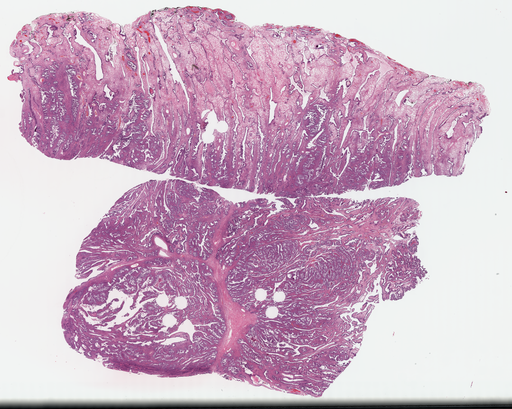

In [ ]:
# preview slide: 
thumb = slide.get_thumbnail((512,512))
thumb

## IMPORT created tiles from slide using HistoClean module

In [7]:
# Path to folder
tile_folder = './images/tiled_images/wsi_ovary'

# Get all image paths (supports png/jpg/jpeg)
image_paths = sorted(glob.glob(os.path.join(tile_folder, '*.png')))  # or '*.jpg'

# Load images
tiles = []
for path in image_paths:
    img = Image.open(path).convert('RGB')  # Convert to 3 channels
    img = img.resize((512, 512))  # optional, if size is inconsistent
    tiles.append(np.array(img))

# Stack into array: shape (N, 512, 512, 3)
X = np.stack(tiles)

X = X.astype(np.float32) / 255.0

In [8]:
print("Shape of X:", X.shape)  # (num_tiles, 512, 512, 3)
print("Type of X:", X.dtype)  # Should be float32

Shape of X: (1306, 512, 512, 3)
Type of X: float32


In [11]:
# 80% train, 20% test
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Type of X_train:", X_train.dtype)  # Should be float32
print("Type of X_test:", X_test.dtype)  # Should be float32

Train shape: (1044, 512, 512, 3)
Test shape: (262, 512, 512, 3)
Type of X_train: float32
Type of X_test: float32


# Build and train the autoencoder

In [12]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

input_shape = (512, 512, 3)

In [ ]:
# --- Encoder ---
inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x) 
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x) 
# x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
# x = layers.MaxPooling2D(2, padding='same')(x) 

# Flatten spatial grid into a sequence: (batch, 64*64, 128)
x = layers.Reshape((64 * 64, 128))(x)

# Apply Conv1D across the sequence (optional kernel size = 1 or 3)
x = layers.Conv1D(1, kernel_size=1, activation='linear')(x)  # (batch, 4096, 1)

# Reshape to (64, 64)
latent = layers.Reshape((64, 64))(x)

2025-07-09 15:16:32.373268: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-07-09 15:16:32.373632: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-09 15:16:32.373642: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-09 15:16:32.373933: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-09 15:16:32.374043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# --- Decoder ---
# Add channel dimension back → (64, 64, 1)
x = Lambda(lambda x: K.expand_dims(x, axis=-1))(latent)

# Restore to 128 filters
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)

# x = layers.Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)

# Final Output
outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

In [15]:
autoencoder = models.Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 512, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4096, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 4096, 1)        │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 128, 128, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 256, 256, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 512, 512, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 512, 512, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,364 (1.28 MB)

 Trainable params: 335,364 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
autoencoder.fit(X_train, X_train, epochs=100, batch_size=8, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/100


2025-07-09 15:16:54.396114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 273ms/step - loss: 0.6242 - val_loss: 0.5562
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 247ms/step - loss: 0.5544 - val_loss: 0.5523
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 250ms/step - loss: 0.5527 - val_loss: 0.5513
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 255ms/step - loss: 0.5492 - val_loss: 0.5511
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 248ms/step - loss: 0.5460 - val_loss: 0.5503
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 253ms/step - loss: 0.5496 - val_loss: 0.5504
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 247ms/step - loss: 0.5494 - val_loss: 0.5499
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 247ms/step - loss: 0.5486 - val_loss: 0.5496
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 248ms/step - loss: 0.5470 - val_loss: 0.5523
Epoch 10/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 248ms/step - loss: 0.5467 - val_loss: 0.5498
Epoch 11/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 250ms/step - loss: 0.5453 - val_loss: 0.5504
Epoch 12/100
131/131

## Visualise the reconstructions side by side 

In [17]:
def show_reconstructions(model, X_data, n=5):
    """
    Show 'n' original and reconstructed images side-by-side.
    
    Parameters:
        model: trained autoencoder
        X_data: input data, shape (N, 512, 512, 3)
        n: number of images to display
    """
    decoded_imgs = model.predict(X_data[:n])

    plt.figure(figsize=(2 * n, 4))
    for i in range(n):
        # Original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_data[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


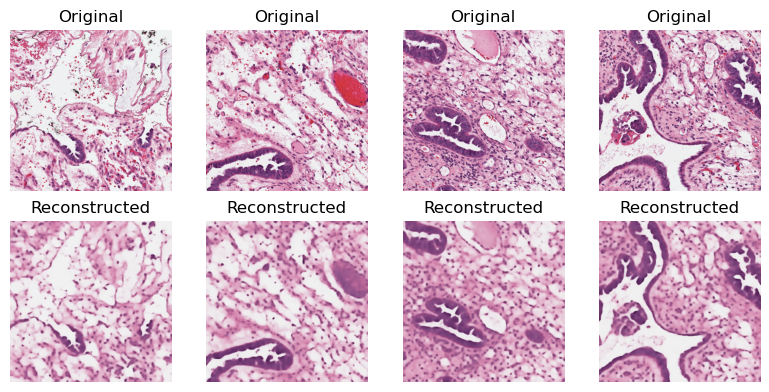

In [18]:
show_reconstructions(autoencoder, X, n=4)

## Save images to disk for size comparison. 

In [19]:
from tensorflow.keras.models import Model

# Suppose this is your encoder model:
encoder = Model(inputs=autoencoder.input, outputs=latent)

# Select an image
sample = X[1:2]  # shape (1, H, W, C)

# Get latent vector
compressed = encoder.predict(sample) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


In [20]:
sample.shape

(1, 512, 512, 3)

In [21]:
compressed.shape

(1, 64, 64)

In [22]:
np.save('compressed_sample.npy', compressed)

In [23]:
compressed.tofile('compressed_sample.bin')

In [24]:
# Assuming input image is scaled 0-1 and needs converting back to 0–255
img = (sample[0] * 255).astype(np.uint8)

# Save as PNG
Image.fromarray(img).save("original_image.png")

In [25]:
# copy of above make compressed to img ??
comp = (compressed[0] * 255).astype(np.uint8)

# Save as PNG
Image.fromarray(comp).save("compressed_image.png")

In [26]:
decoded = autoencoder.predict(X[1:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


In [27]:
decoded.shape

(1, 512, 512, 3)

In [28]:
# output image is scaled 0-1 and needs converting back to 0–255
decoded_img = (decoded[0] * 255).astype(np.uint8)

# Save as PNG
Image.fromarray(decoded_img).save("reconstructed_image.png")

In [29]:
import os

original_size = os.path.getsize("original_image.png")
compressed_image_size = os.path.getsize("compressed_image.png")
compressed_size = os.path.getsize("compressed_sample.npy")
compressed_bin = os.path.getsize("compressed_sample.bin")
reconstructed_size = os.path.getsize("reconstructed_image.png")

print(f"Original image size: {original_size / 1024:.2f} KB")
print(f"Compressed image size: {compressed_image_size / 1024:.2f} KB")
print(f"Compressed latent size npy: {compressed_size / 1024:.2f} KB")
print(f"Compressed latent size bin: {compressed_bin / 1024:.2f} KB")
print(f"Reconstructed image size: {reconstructed_size / 1024:.2f} KB")

Original image size: 534.43 KB
Compressed image size: 4.13 KB
Compressed latent size npy: 16.12 KB
Compressed latent size bin: 16.00 KB
Reconstructed image size: 344.64 KB


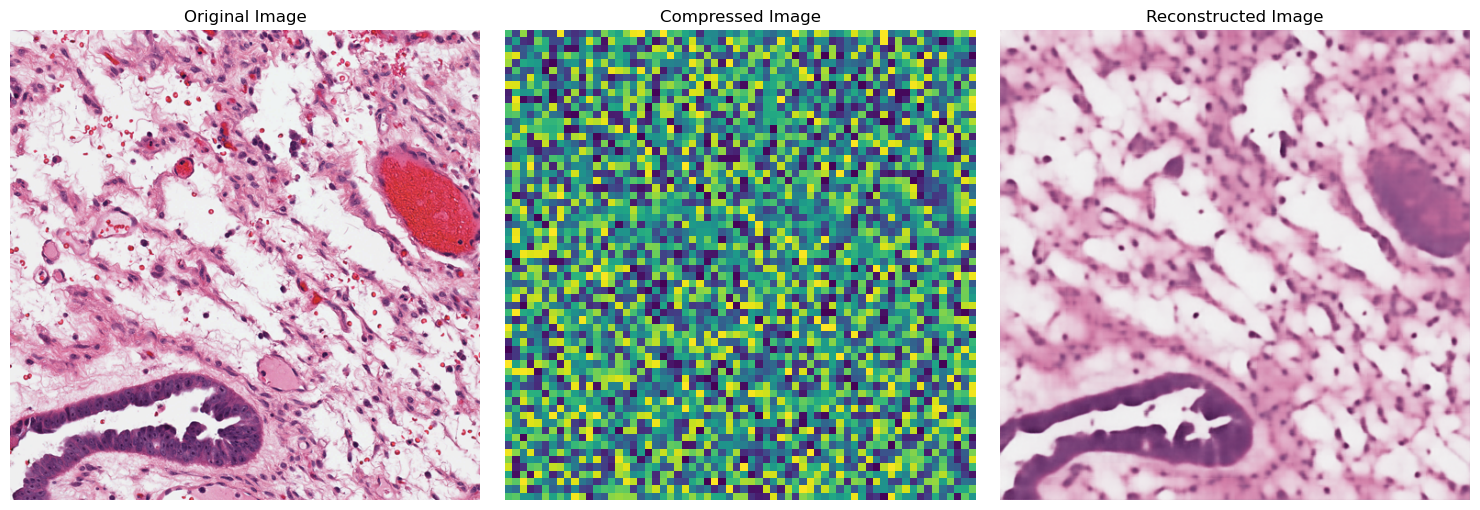

In [30]:
# Load the images
original = Image.open("original_image.png")
compressed = Image.open("compressed_image.png")
reconstructed = Image.open("reconstructed_image.png")

# Get file sizes in KB
# original_size = os.path.getsize("original_image.png") / 1024
# compressed_size = os.path.getsize("compressed_image.png") / 1024
# reconstructed_size = os.path.getsize("reconstructed_image.png") / 1024

# Create side-by-side display
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title(f"Original Image") #\n{original_size:.2f} KB
plt.axis("off")

# Compressed image
plt.subplot(1, 3, 2)
plt.imshow(compressed)
plt.title(f"Compressed Image") #\n{compressed_size:.2f} KB")
plt.axis("off")

# Reconstructed
plt.subplot(1, 3, 3)
plt.imshow(reconstructed)
plt.title(f"Reconstructed Image") #\n{reconstructed_size:.2f} KB")
plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

## Extract latent vectors from new WSI_heart files using autoencoder to predict

In [31]:
# Path to folder
tile_folder = './images/tiled_images/wsi_heart'

# Get all image paths (supports png/jpg/jpeg)
image_paths = sorted(glob.glob(os.path.join(tile_folder, '*.png')))  # or '*.jpg'

# Load images
tiles = []
for path in image_paths:
    img = Image.open(path).convert('RGB')  # Convert to 3 channels
    img = img.resize((512, 512))  # optional, if size is inconsistent
    tiles.append(np.array(img))

# Stack into array: shape (N, 512, 512, 3)
Y = np.stack(tiles)

Y = Y.astype(np.float32) / 255.0

In [32]:
print("Shape of Y:", Y.shape)  # (num_tiles, 512, 512, 3)
print("Type of Y:", Y.dtype)  # Should be float32

Shape of Y: (115, 512, 512, 3)
Type of Y: float32


In [ ]:
encoder = models.Model(inputs, latent)
latent_vectors = encoder.predict(Y)  # Shape: (N, 64, 64)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/stepWARNING:tensorflow:5 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x3c9fd5d00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [34]:
latent_flat = latent_vectors.reshape(latent_vectors.shape[0], -1)  # (N, features)

In [35]:
latent_flat.shape

(115, 4096)

# Try to calculate the loss between original vs reconstructed image.

In [36]:
# Binary Crossentropy (BCE) is a loss function that measures the difference between two probability distributions — in our case, the original and reconstructed images interpreted as probabilities per pixel.
from tensorflow.keras.losses import BinaryCrossentropy

# Reconstruct the tiles
reconstructed = autoencoder.predict(Y)

# Define the BCE loss object
bce = BinaryCrossentropy()

# Compute per-image loss
per_image_loss = [bce(Y[i], reconstructed[i]).numpy() for i in range(len(Y))]

# Average loss across all tiles
average_loss = np.mean(per_image_loss)

print(f"BCE Loss for each image: {per_image_loss}\n")
print(f"Average Reconstruction Loss (BCE): {average_loss:.5f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
BCE Loss for each image: [0.35125458, 0.42181405, 0.54578483, 0.5743078, 0.5828458, 0.58401614, 0.5867927, 0.5880611, 0.57779515, 0.51771945, 0.35135382, 0.510547, 0.44111013, 0.54762197, 0.5713871, 0.5813847, 0.5617212, 0.59079266, 0.59392166, 0.5914202, 0.5756332, 0.38267186, 0.5103562, 0.5626209, 0.5184964, 0.3537858, 0.5449756, 0.56589055, 0.57108736, 0.5855627, 0.5909258, 0.59395945, 0.5946272, 0.5876154, 0.5258543, 0.5569234, 0.5674815, 0.5644127, 0.5154927, 0.51880544, 0.5672152, 0.57992244, 0.58960927, 0.59379566, 0.59435296, 0.59140587, 0.38293117, 0.5518531, 0.5468626, 0.5759144, 0.57818824, 0.5583904, 0.5241526, 0.54808545, 0.58891284, 0.592052, 0.59368217, 0.59017444, 0.38401002, 0.54054785, 0.44452584, 0.5242908, 0.38814306, 0.56910074, 0.54795194, 0.5746375, 0.58131766, 0.5689577, 0.5478308, 0.5928893, 0.5924833, 0.588704, 0.36578074, 0.52654743, 0.5341134, 0.57376647, 0.5692264, 0.57238424, 0.5447072, 0.42957616, 0.3620388, 0.462600

In [37]:
# This is the most common for pixel-wise comparison.
# Calculate per-tile MSE
mse_losses = np.mean((Y - reconstructed) ** 2, axis=(1, 2, 3))  # shape: (N,)

# Calculate overall average MSE - LOWER IS BETTER
average_mse = np.mean(mse_losses)

print(f"MSE Loss for each image: {mse_losses}\n")
print(f"Average Reconstruction Loss (MSE): {average_mse:.5f}")

MSE Loss for each image: [0.00175869 0.00373273 0.00632507 0.00694006 0.00693174 0.00657022
 0.00744491 0.00668321 0.00564207 0.00364581 0.00264779 0.00509136
 0.00358263 0.00603953 0.00722748 0.00678585 0.00666443 0.00701496
 0.00722206 0.00746923 0.00623404 0.00250271 0.00433574 0.0063838
 0.00515736 0.0024823  0.00626143 0.00788179 0.00723949 0.00724949
 0.00698718 0.00754421 0.00725436 0.00657151 0.0055161  0.0062449
 0.00724625 0.00698182 0.00550323 0.00636065 0.00906389 0.00779173
 0.00821045 0.00791843 0.00870752 0.00742209 0.00267505 0.0067026
 0.00665614 0.00717153 0.00751369 0.00692004 0.00508427 0.00810895
 0.00848265 0.00791567 0.0084942  0.00737845 0.00294502 0.0057872
 0.00271725 0.00356339 0.00213667 0.00664596 0.00630108 0.0071725
 0.00746142 0.00702322 0.00552395 0.00796587 0.0089648  0.00817176
 0.00255543 0.00581627 0.00633276 0.00628686 0.00715687 0.00605294
 0.00629699 0.00391626 0.00207203 0.00511633 0.00718232 0.00494425
 0.00626189 0.00580351 0.00628063 0.005586

In [38]:
# Calculate Structural Similarity Index (SSIM)
ssim_val = tf.image.ssim(Y, reconstructed, max_val=1.0)

# Calculate overall average SSIM - HIGHER IS BETTER
average_ssim = np.mean(ssim_val)

print(f"SSIM Loss for each image: {ssim_val}\n")
print(f"Average SSIM Loss: {average_ssim:.5f}")

SSIM Loss for each image: [0.66665727 0.49512896 0.32051605 0.29720953 0.3030156  0.3119564
 0.30130947 0.315236   0.3374716  0.42243382 0.6203703  0.3625965
 0.4828564  0.32582036 0.28919122 0.30270192 0.36138836 0.31885913
 0.31771755 0.32215473 0.32502666 0.59646624 0.3975403  0.30443797
 0.36260918 0.6350247  0.30721214 0.29542887 0.3119757  0.2933758
 0.31011647 0.3095102  0.29121593 0.31766176 0.34652933 0.30521396
 0.28219828 0.26748288 0.33379936 0.35621548 0.2612501  0.2814147
 0.27108973 0.25968292 0.27413186 0.27323675 0.58970493 0.30882204
 0.3293748  0.26373369 0.25042143 0.27802634 0.3213942  0.30359653
 0.25659904 0.27327278 0.26269257 0.2823873  0.5852054  0.35585555
 0.5425239  0.41431403 0.6244188  0.2705437  0.3396773  0.26911935
 0.24369967 0.27092505 0.2988102  0.26425037 0.2719099  0.28575695
 0.61944586 0.34858474 0.33151034 0.2848995  0.27260372 0.2896764
 0.3081978  0.5310046  0.6294905  0.49881876 0.2939768  0.34019005
 0.3260561  0.3901317  0.3016565  0.32826

In [39]:
# Calculate Peak Signal-to-noise Ratio (PSNR)
psnr_val = tf.image.psnr(Y, reconstructed, max_val=1.0)

# Calculate overall average PSNR - Up to 50. HIGHER IS BETTER
average_psnr = np.mean(psnr_val)

print(f"PSNR Loss for each image: {psnr_val}\n")
print(f"Average PSNR Loss: {average_psnr:.5f}")

PSNR Loss for each image: [27.548103 24.279728 21.989346 21.586369 21.591576 21.824202 21.281404
 21.750147 22.485617 24.382057 25.771162 22.931658 24.45798  22.189968
 21.410131 21.683954 21.762365 21.539743 21.413383 21.267237 22.052301
 26.015896 23.629364 21.949207 22.875729 26.051458 22.033264 21.03375
 21.40292  21.396929 21.55698  21.223864 21.394005 21.823345 22.58368
 22.044744 21.398863 21.560312 22.59382  21.964985 20.426851 21.08366
 20.856327 21.013609 20.601053 21.294737 25.726673 21.737568 21.767775
 21.44388  21.241465 21.598915 22.937716 20.910355 20.714685 21.015123
 20.708775 21.320345 25.309113 22.375317 25.658697 24.481365 26.702623
 21.77442  22.005848 21.443293 21.271782 21.534637 22.577497 20.987665
 20.474592 20.876842 25.925354 22.353552 21.984072 22.015665 21.452768
 22.180332 22.00867  24.071283 26.836039 22.910418 21.437353 23.05899
 22.032942 22.363092 22.019966 22.528408 23.087812 24.363245 22.801966
 22.034369 22.459986 25.433409 24.385542 23.778751 24.1

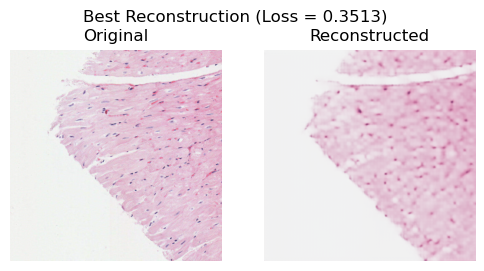

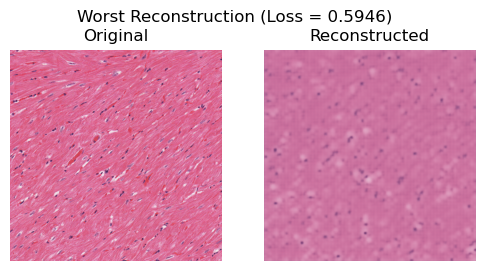

In [ ]:
# Show best and worst ... REALLY INTERESTING! 

# Get indices of best and worst
best_idx = np.argmin(per_image_loss)
worst_idx = np.argmax(per_image_loss)

def show_tile_comparison(index, title):
    plt.figure(figsize=(6, 3))
    plt.suptitle(title)

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(Y[index])
    plt.title("Original")
    plt.axis("off")

    # Reconstruction
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed[index])
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

show_tile_comparison(best_idx, f"Best Reconstruction (Loss = {per_image_loss[best_idx]:.4f})")
show_tile_comparison(worst_idx, f"Worst Reconstruction (Loss = {per_image_loss[worst_idx]:.4f})")

In [41]:
original_image = Y[0]
print("ORIGINAL IMAGE - Shape: ", original_image.shape, ", Size: ", original_image.size)

latent_vector = latent_vectors[0]
print("LATENT VECTOR - Shape: ", latent_vector.shape, ", Size: ", latent_vector.size)

# Percentage compression achieved.
compression_percentages = []

for original_image, latent_vector in zip(Y, latent_vectors):
    original_size = original_image.size
    latent_size = latent_vector.size
    # Calc percent for each tile
    percent = (1 - (latent_size / original_size)) * 100
    compression_percentages.append(percent)

average_compression = np.mean(compression_percentages)
print("Average compression across all tiles: {:.2f}%".format(average_compression))

ORIGINAL IMAGE - Shape:  (512, 512, 3) , Size:  786432
LATENT VECTOR - Shape:  (64, 64) , Size:  4096
Average compression across all tiles: 99.48%
